# **Experiment Notebook**



## Context


### 0. Import Packages

In [2]:
! pip install -r https://raw.githubusercontent.com/aso-uts/labs_datasets/main/36106-mlaa/requirements.txt

In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


Libraries used in the model resolution.

In [4]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import statistics
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
from category_encoders import TargetEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.utils import resample
from scipy.stats import chi2_contingency
import matplotlib.patches as mpatches

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)

### 1.   Load Dataset

Combination of all the require datasets.

In [5]:
path = os.getcwd()
all_files = glob.glob(path + "/*.csv")
del all_files[0]

In [6]:
customers = pd.read_csv('customers.csv', delimiter='|')

In [7]:
df_list = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0,  delimiter='|', on_bad_lines='skip')
    
    base = os.path.basename(filename)  #
    transaction_id = int(base.split('_')[-1].split('.')[0]) 
    df['transaction_id'] = transaction_id  
    
    df_list.append(df)
    

df_list = [df.dropna(axis=1, how='all') for df in df_list]

transactions= pd.concat(df_list, axis=0, ignore_index=True)

Merge of Customers with Transactions.

In [8]:
df_final = transactions.merge(customers.drop('acct_num', axis=1), on='cc_num')

In [9]:
df_final.head(2)

,cc_num,acct_num,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,transaction_id,ssn,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob
0,4218196001337,888022315787,91ab12e73ef38206e1121e9648d2408d,1558719550,gas_transport,69.12,0,Phillips Group,39.491416,-75.588522,0,115-04-4507,Jonathan,Johnson,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03
1,4218196001337,888022315787,071553d533a6822a4431c354c434ddcb,1569425519,grocery_pos,68.11,0,Tucker Ltd,40.890319,-75.573359,0,115-04-4507,Jonathan,Johnson,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03


### 2. Explore Dataset

In [10]:
df_final['unix_time'] = pd.to_datetime(df_final['unix_time'], unit='s')

<Axes: xlabel='Count', ylabel='unix_time'>

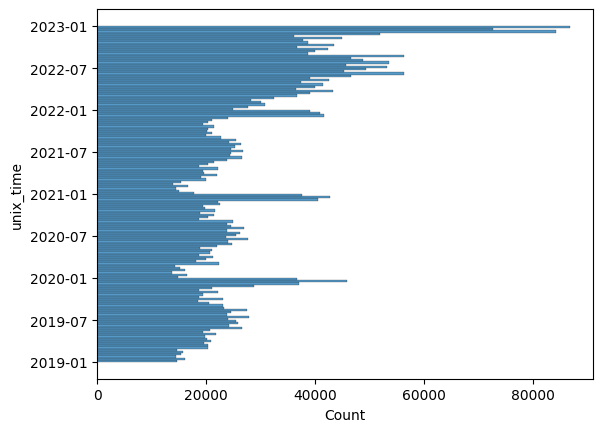

In [11]:
sns.histplot(data=df_final, y=df_final.unix_time)

In [12]:
max_date = '2022-06-01'

In [13]:
df = df_final[(df_final['unix_time'] >= max_date )].reset_index(drop=True).copy(deep = True)

<Axes: xlabel='Count', ylabel='unix_time'>

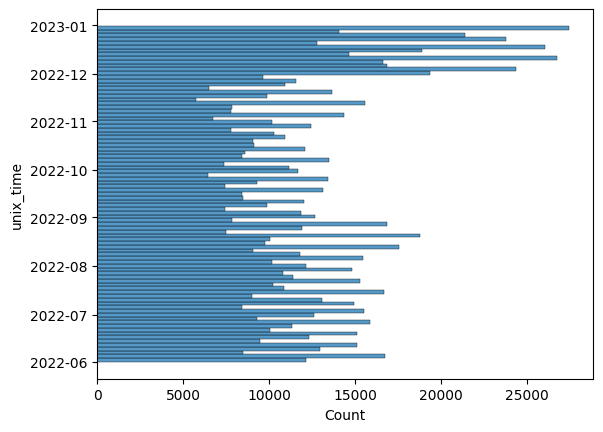

In [14]:
sns.histplot(data=df, y=df.unix_time)

In [15]:
df['hour'] = df['unix_time'].dt.hour
df['day_of_week'] = df['unix_time'].dt.weekday
df['month'] = df['unix_time'].dt.month

In [16]:
df.drop(columns=['unix_time'],inplace=True)

Data type within the dataset.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117411 entries, 0 to 1117410
Data columns (total 26 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   cc_num          1117411 non-null  int64  
 1   acct_num        1117411 non-null  int64  
 2   trans_num       1117411 non-null  object 
 3   category        1117411 non-null  object 
 4   amt             1117411 non-null  float64
 5   is_fraud        1117411 non-null  int64  
 6   merchant        1117411 non-null  object 
 7   merch_lat       1117411 non-null  float64
 8   merch_long      1117411 non-null  float64
 9   transaction_id  1117411 non-null  int64  
 10  ssn             1117411 non-null  object 
 11  first           1117411 non-null  object 
 12  last            1117411 non-null  object 
 13  gender          1117411 non-null  object 
 14  street          1117411 non-null  object 
 15  city            1117411 non-null  object 
 16  state           1117411 non-null  ob

In [18]:
# We can eliminate transaction_id and ssn because they are unique identifiers
# We also remove first , last, street, city, zip, lat, long and city_pop because they are specific to the customer
df.drop(columns=['transaction_id','ssn','first','last','street','city','zip','lat','long','city_pop'],inplace=True)

We need to transform DOB first to datetime and then to age.

In [19]:
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = df['dob'].apply(lambda x: datetime.datetime.now().year - x.year - ((datetime.datetime.now().month, datetime.datetime.now().day) < (x.month, x.day)))

In [20]:
df.drop(columns=['dob'],inplace=True)

Null Check

In [21]:
null_counts = df.isnull().sum()

null_percentage = (df.isnull().sum() / len(df)) * 100

null_info = pd.DataFrame({'Null_Counts': null_counts, 'Percentage': null_percentage})

print(null_info)

             Null_Counts  Percentage
cc_num                 0         0.0
acct_num               0         0.0
trans_num              0         0.0
category               0         0.0
amt                    0         0.0
is_fraud               0         0.0
merchant               0         0.0
merch_lat              0         0.0
merch_long             0         0.0
gender                 0         0.0
state                  0         0.0
job                    0         0.0
hour                   0         0.0
day_of_week            0         0.0
month                  0         0.0
age                    0         0.0


There are no null values in the dataset to be analysed. 

Outliers Identification

In [22]:
outliers_dict = {}

for column in df.select_dtypes(include=['number']).columns:
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    outliers = z_scores > 4
    outliers_dict[column] = outliers.sum()

outliers_df = pd.DataFrame(list(outliers_dict.items()), columns=['Column', 'Outliers'])

print(outliers_df)

        Column  Outliers
0       cc_num         0
1     acct_num         0
2          amt      5884
3     is_fraud      1669
4    merch_lat      6431
5   merch_long         0
6         hour         0
7  day_of_week         0
8        month         0
9          age         0


Visual representation of the outliers

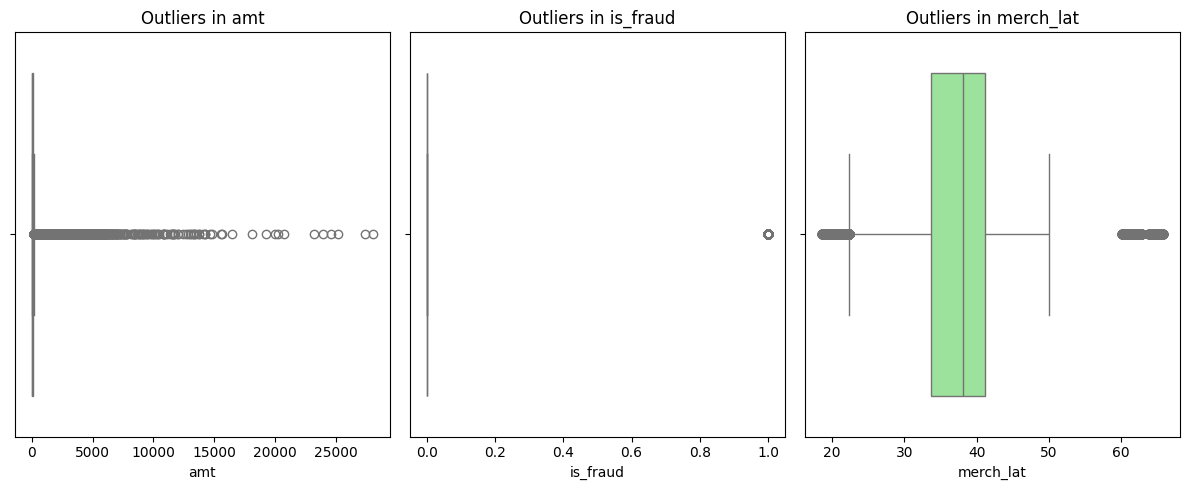

In [23]:
columns_of_interest = ['amt','is_fraud','merch_lat']

num_rows = (len(columns_of_interest) + 2) // 3

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(12, 5 * num_rows))

axes = axes.flatten()

for i, col in enumerate(columns_of_interest):
    sns.boxplot(x=df[col], ax=axes[i],color='lightgreen')
    axes[i].set_title(f'Outliers in {col}')
    axes[i].set_xlabel(col)

for j in range(len(columns_of_interest), num_rows * 3):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Analysis of the distribution of the numerical variables.

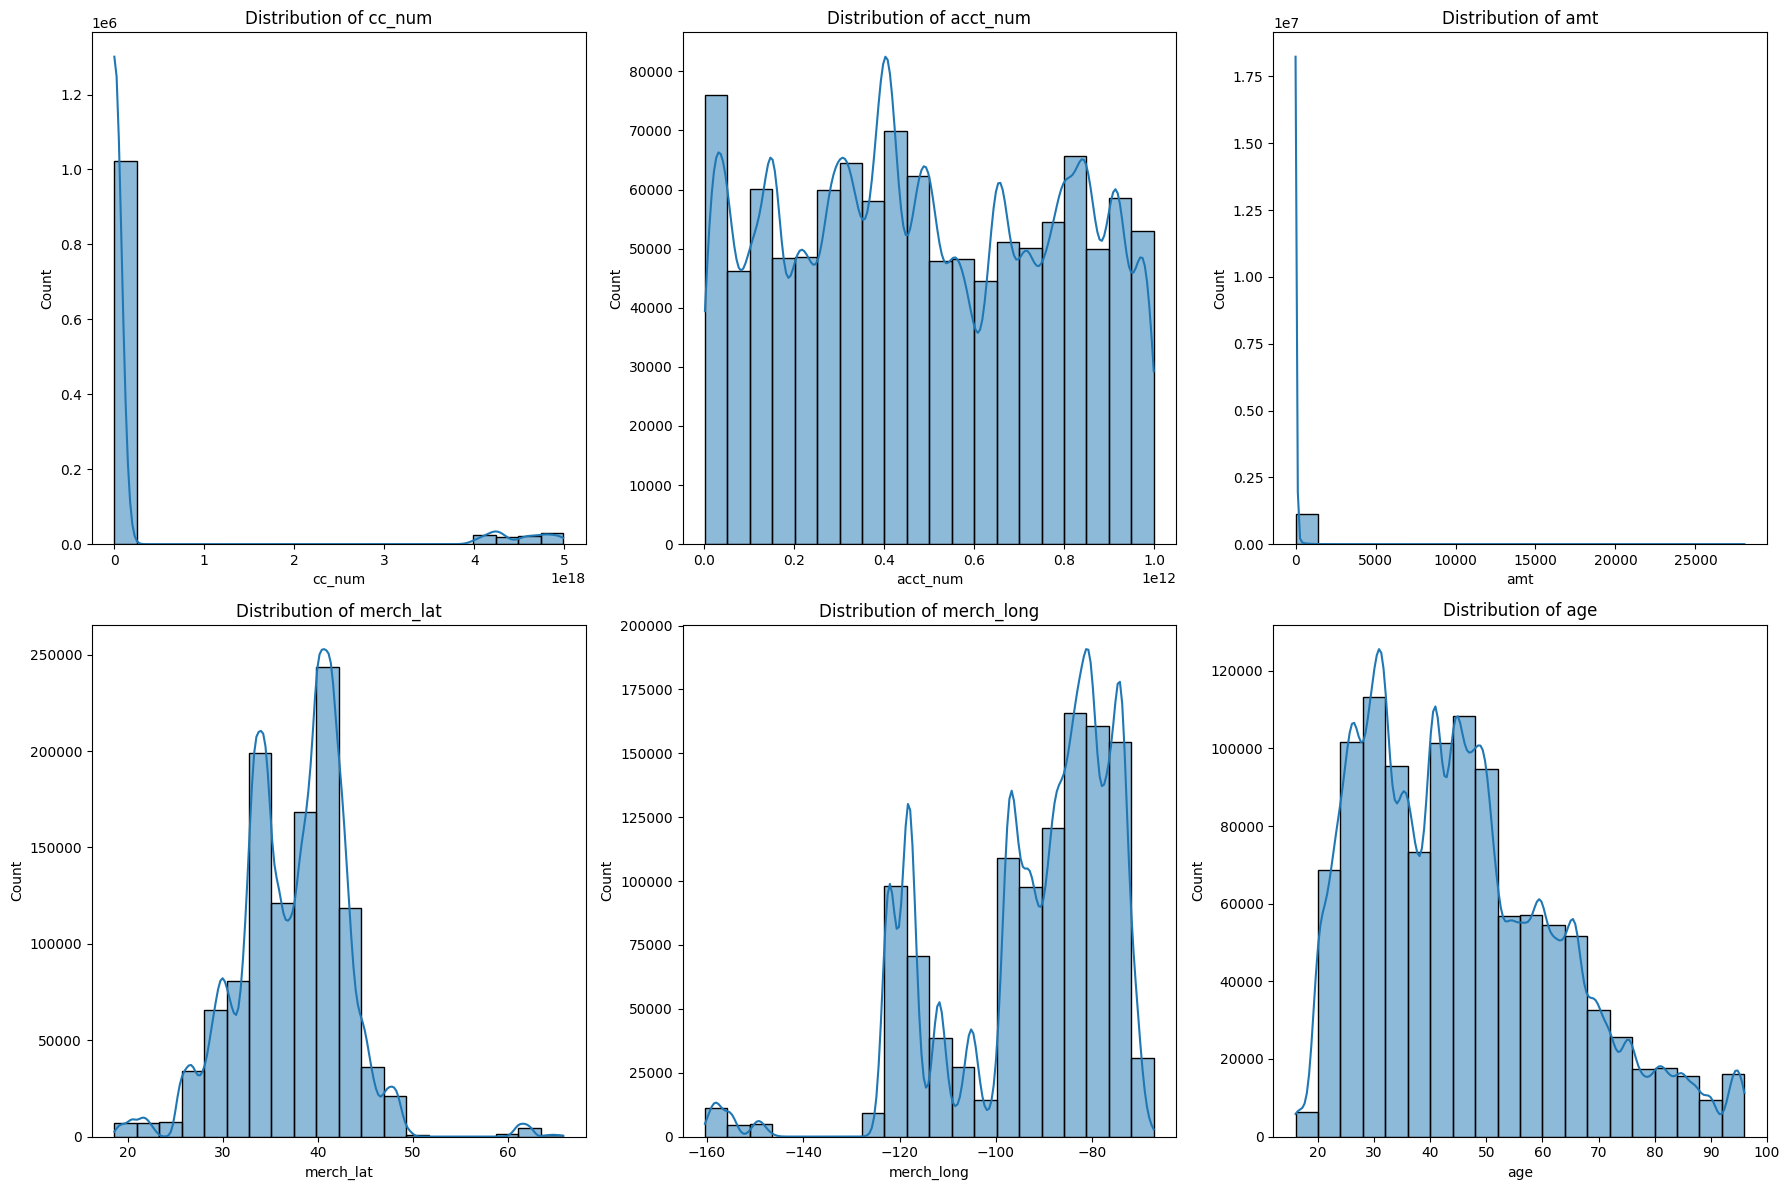

In [24]:
columns_of_interest = df.select_dtypes(include=['float64','int64']).columns.drop('is_fraud')
n_rows = len(columns_of_interest) // 3 + (len(columns_of_interest) % 3 > 0)

plt.figure(figsize=(18, 6 * n_rows))

for i, col in enumerate(columns_of_interest, 1):
    plt.subplot(n_rows, 3, i)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

Heat map

To see the relationship between multiple attributes.

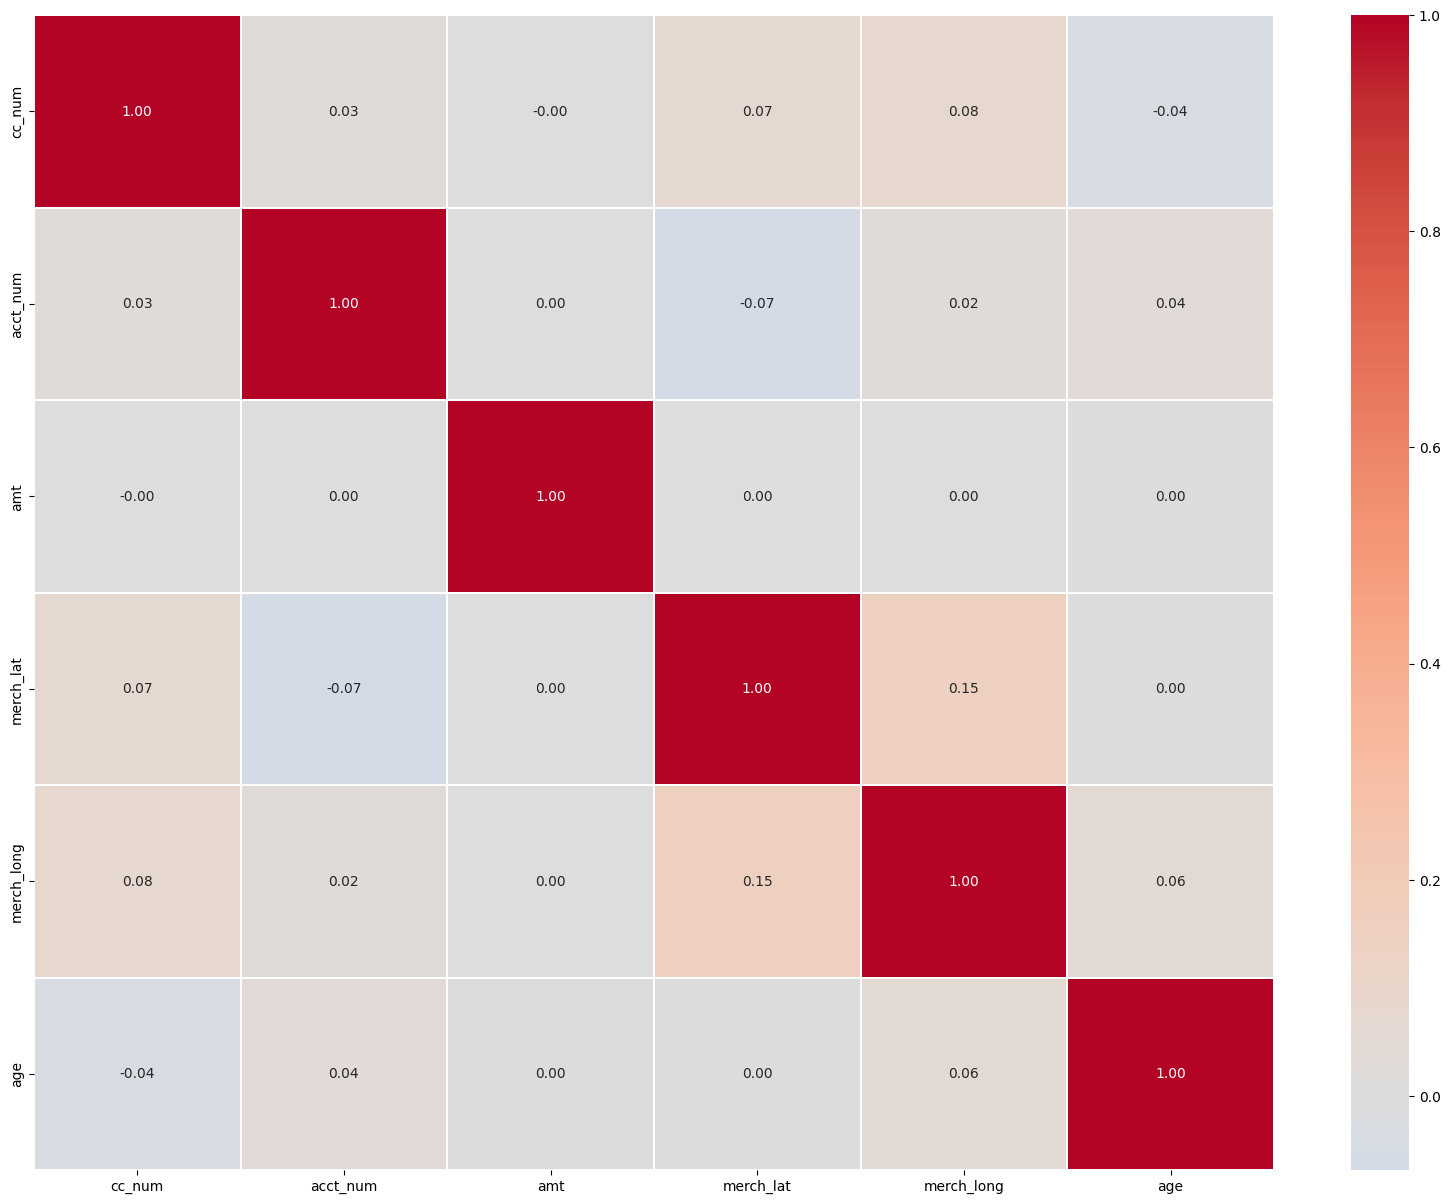

In [25]:
numeric_cols = df.select_dtypes(include=['float64','int64']).columns.drop('is_fraud')
corr = df[numeric_cols].corr()

f, ax = plt.subplots(figsize=(20, 15))

sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, linewidths=.3, fmt=".2f")

plt.show()

From the correlation map we can see that the correlated variables are:

In [26]:
threshold = 0.8

corr_matrix = df[numeric_cols].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

corr_pairs = corr_matrix.where(mask)
high_corr_vars = [(col, row, corr_pairs.at[row, col]) for col in corr_pairs.columns for row in corr_pairs.index if (corr_pairs.at[row, col] > threshold) and (row != col)]

for col, row, value in high_corr_vars:
    print(f"{col} and {row} have a correlation coefficient of {value}")

### 3. Explore Target variable

The target variable is 'is_fraud', as it it intended to analyse fraudulent transactions.

In [27]:
target ='is_fraud'

In [28]:
df[target]

0          0
1          0
2          0
3          0
4          0
          ..
1117406    0
1117407    0
1117408    0
1117409    0
1117410    0
Name: is_fraud, Length: 1117411, dtype: int64

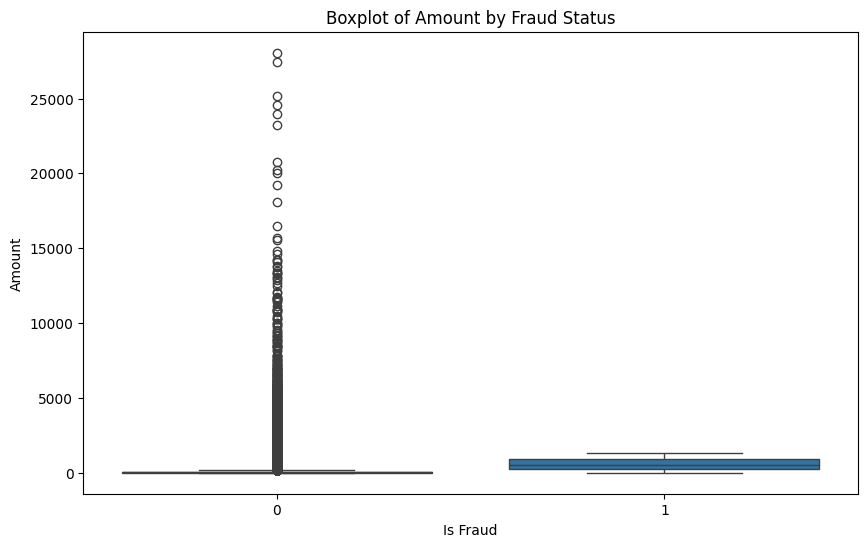

In [29]:
plt.figure(figsize=(10, 6))


sns.boxplot(data=df, x='is_fraud', y='amt')

plt.xlabel('Is Fraud')
plt.ylabel('Amount')
plt.title('Boxplot of Amount by Fraud Status')

plt.show()

([0, 1], [Text(0, 0, '0'), Text(1, 0, '1')])

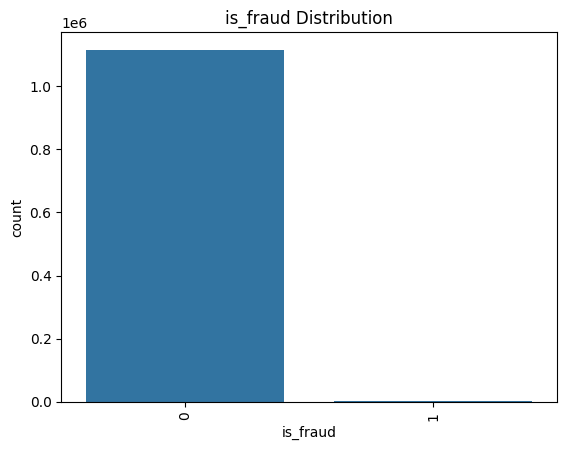

In [30]:
sns.countplot(data=df, x=target, order=df[target].value_counts().index)
plt.title(f'{target} Distribution')
plt.xticks(rotation=90)

In [37]:
df.drop(columns=['cc_num', 'acct_num', 'trans_num'], inplace=True)

### 4. Explore Variables of Interest

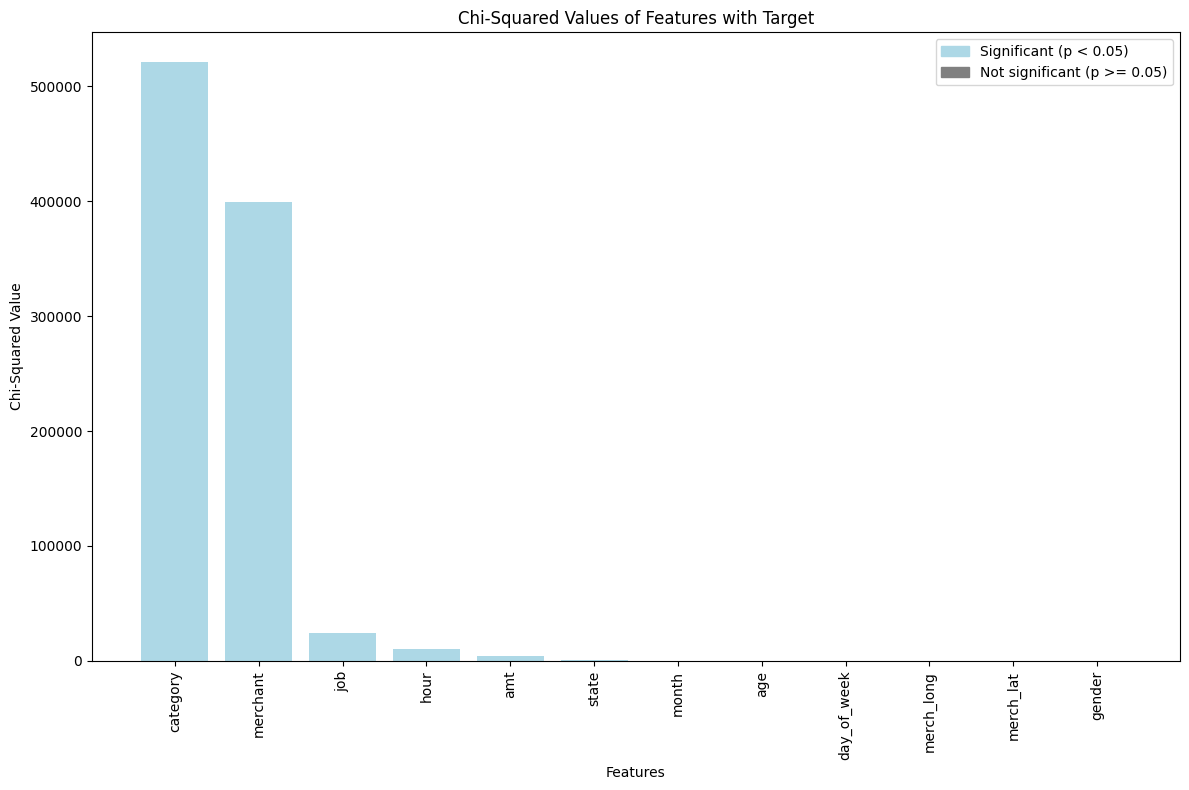

In [38]:
chi2_values = []
p_values = []
columns = []

for column in df.columns:
    if column != target:
        if df[column].dtype in ['int64', 'float64']:

            df['bin'] = pd.qcut(df[column], q=5, duplicates='drop')
            cross_tab = pd.crosstab(df['bin'], df[target])
            df.drop('bin', axis=1, inplace=True)
        else:
            cross_tab = pd.crosstab(df[column], df[target])

        chi2, p, _, _ = chi2_contingency(cross_tab)
        chi2_values.append(chi2)
        p_values.append(p)
        columns.append(column)

sorted_indices = np.argsort(chi2_values)[::-1]
sorted_chi2 = np.array(chi2_values)[sorted_indices]
sorted_columns = np.array(columns)[sorted_indices]
sorted_p_values = np.array(p_values)[sorted_indices]

plt.figure(figsize=(12, 8))

significant_bar = mpatches.Patch(color='lightblue', label='Significant (p < 0.05)')
not_significant_bar = mpatches.Patch(color='gray', label='Not significant (p >= 0.05)')

for i, p in enumerate(sorted_p_values):
    color = 'lightblue' if p < 0.05 else 'gray'
    plt.bar(sorted_columns[i], sorted_chi2[i], color=color)

plt.title('Chi-Squared Values of Features with Target')
plt.ylabel('Chi-Squared Value')
plt.xlabel('Features')
plt.xticks(rotation=90)

plt.legend(handles=[significant_bar, not_significant_bar])

plt.tight_layout()
plt.show()

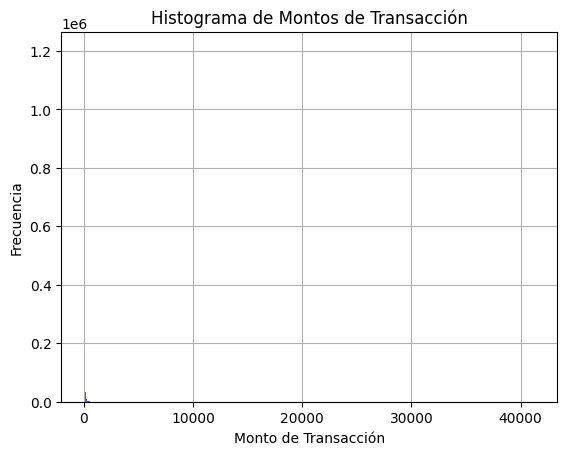

In [39]:
plt.hist(df_final['amt'], bins=range(int(df_final['amt'].min()), int(df_final['amt'].max()) + 10, 10), color='blue', alpha=0.7)
plt.title('Histograma de Montos de Transacción')
plt.xlabel('Monto de Transacción')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [40]:
print(df_final['amt'].describe(percentiles=[.25, .5, .75, .95, .99]))

count    4.260904e+06
mean     6.898790e+01
std      1.618467e+02
min      1.000000e+00
25%      9.100000e+00
50%      4.449000e+01
75%      8.158000e+01
95%      2.042400e+02
99%      5.023800e+02
max      4.130053e+04
Name: amt, dtype: float64


### 5. Prepare Data

In [28]:
def data_preprocessing (data):
  data_new = data.copy()

  data_new = transactions.merge(customers.drop('acct_num', axis=1), on='cc_num')

  data_new['unix_time'] = pd.to_datetime(data_new['unix_time'], unit='s')

  max_date = '2022-09-01'
  data_new[(data_new['unix_time'] >= max_date )].reset_index(drop=True).copy(deep = True)

  data_new['hour'] = data_new['unix_time'].dt.hour
  data_new['day_of_week'] = data_new['unix_time'].dt.weekday
  data_new['month'] = data_new['unix_time'].dt.month

  data_new.sort_values(by=['acct_num', 'unix_time'], inplace=True)
  data_new['time_since_last_transaction'] = data_new.groupby('acct_num')['unix_time'].diff()
  data_new['time_since_last_transaction'] = data_new['time_since_last_transaction'].dt.total_seconds()
  data_new['time_since_last_transaction'] = data_new['time_since_last_transaction'].fillna(0)

  data_new.drop(columns=['unix_time'],inplace=True)

  data_new.drop(columns=['transaction_id','ssn','first','last','street','city','lat','long','city_pop','job','gender','merchant','trans_num','acct_num','cc_num'],inplace=True)

  data_new['dob'] = pd.to_datetime(data_new['dob'])
  data_new['age'] = data_new['dob'].apply(lambda x: datetime.datetime.now().year - x.year - ((datetime.datetime.now().month, datetime.datetime.now().day) < (x.month, x.day)))
  data_new.drop(columns=['dob'],inplace=True)

  numeric_cols = data_new.select_dtypes(include=['float64','int64']).columns.drop('is_fraud')
  scaler = MinMaxScaler()
  data_new[numeric_cols] = scaler.fit_transform(data_new[numeric_cols])



  return data_new

In [29]:
data_preprocessing(df_final).head()

,category,amt,is_fraud,merch_lat,merch_long,state,zip,hour,day_of_week,month,time_since_last_transaction,age
1325951,gas_transport,0.002301,0,0.538577,0.894325,NY,0.132981,21,0,12,0.000000,0.3875
1326297,gas_transport,0.000210,0,0.501927,0.885975,NY,0.132981,16,1,1,0.000740,0.3875
1325992,gas_transport,0.000992,0,0.525005,0.894014,NY,0.132981,16,1,1,0.000005,0.3875
1326118,gas_transport,0.001762,0,0.517837,0.898346,NY,0.132981,16,1,1,0.000015,0.3875
1326314,gas_transport,0.008689,0,0.541872,0.879892,NY,0.132981,13,2,1,0.000768,0.3875


### 6. Split Dataset

In this step it is vital to divide the dataset into a training, validation and testing set to be able to evaluate the performance of the model.

In [30]:
df_modeling = data_preprocessing(df_final)

In [31]:
y = df_modeling['is_fraud']
X = df_modeling.drop('is_fraud',axis=1)

In [32]:
X_model, X_test, y_model, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify = y)

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.20, random_state=42, stratify = y_model)

In [34]:
encoder = TargetEncoder()
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)
X_val = encoder.transform(X_val)

### 7. Baseline Model

In [35]:
mod = statistics.mode(y)

In [36]:
y_central_train = np.full(y_train.shape,mod)
y_central_val = np.full(y_val.shape,mod)
y_central_test = np.full(y_test.shape,mod)

In [37]:
accuracy_train_base = accuracy_score(y_train, y_central_train)
precision_train_base = precision_score(y_train, y_central_train, average='macro', zero_division=0)
recall_train_base = recall_score(y_train, y_central_train, average='macro')
f1_train_base = f1_score(y_train, y_central_train, average='macro')

accuracy_val_base = accuracy_score(y_val,y_central_val)
precision_val_base = precision_score(y_val,y_central_val, average='macro', zero_division=0)
recall_val_base = recall_score(y_val,y_central_val, average='macro')
f1_val_base = f1_score(y_val,y_central_val, average='macro')

accuracy_test_base = accuracy_score(y_test, y_central_test)
precision_test_base = precision_score(y_test, y_central_test, average='macro', zero_division=0)
recall_test_base = recall_score(y_test, y_central_test, average='macro')
f1_test_base = f1_score(y_test, y_central_test, average='macro')

In [38]:
print(f"Accuracy Training: {accuracy_train_base:.4f}")
print(f"Precision Training: {precision_train_base:.4f}")
print(f"Recall Training: {recall_train_base:.4f}")
print(f"F1 Score Training: {f1_train_base:.4f}")
print(" ")
print(f"Accuracy Validation: {accuracy_val_base:.4f}")
print(f"Precision Validation: {precision_val_base:.4f}")
print(f"Recall Validation: {recall_val_base:.4f}")
print(f"F1 Score Validation: {f1_val_base:.4f}")
print(" ")
print(f"Accuracy Testing: {accuracy_test_base:.4f}")
print(f"Precision Testing: {precision_test_base:.4f}")
print(f"Recall Testing: {recall_test_base:.4f}")
print(f"F1 Score Testing: {f1_test_base:.4f}")

Accuracy Training: 0.9988
Precision Training: 0.4994
Recall Training: 0.5000
F1 Score Training: 0.4997
 
Accuracy Validation: 0.9988
Precision Validation: 0.4994
Recall Validation: 0.5000
F1 Score Validation: 0.4997
 
Accuracy Testing: 0.9988
Precision Testing: 0.4994
Recall Testing: 0.5000
F1 Score Testing: 0.4997


### 8. Train Machine Learning Model

In [39]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

xgb_model = xgb.XGBClassifier(scale_pos_weight=sum(y_train_resampled == 0) / sum(y_train_resampled == 1))
xgb_model.fit(X_train_resampled, y_train_resampled)

y_pred_train = xgb_model.predict(X_train)
y_pred_val = xgb_model.predict(X_val)
y_pred_test = xgb_model.predict(X_test)

In [40]:
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average='macro')
recall_train = recall_score(y_train, y_pred_train, average='macro')
f1_train = f1_score(y_train, y_pred_train, average='macro')

accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val, average='macro')
recall_val = recall_score(y_val, y_pred_val, average='macro')
f1_val = f1_score(y_val, y_pred_val, average='macro')

accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='macro')
recall_test = recall_score(y_test, y_pred_test, average='macro')
f1_test = f1_score(y_test, y_pred_test, average='macro')


print(f"Accuracy Training: {accuracy_train:.4f}")
print(f"Precision Training: {precision_train:.4f}")
print(f"Recall Training: {recall_train:.4f}")
print(f"F1 Score Training: {f1_train:.4f}")
print(" ")
print(f"Accuracy Validation: {accuracy_val:.4f}")
print(f"Precision Validation: {precision_val:.4f}")
print(f"Recall Validation: {recall_val:.4f}")
print(f"F1 Score Validation: {f1_val:.4f}")
print(" ")
print(f"Accuracy Testing: {accuracy_test:.4f}")
print(f"Precision Testing: {precision_test:.4f}")
print(f"Recall Testing: {recall_test:.4f}")
print(f"F1 Score Testing: {f1_test:.4f}")


Accuracy Training: 0.9971
Precision Training: 0.6356
Recall Training: 0.9334
F1 Score Training: 0.7061
 
Accuracy Validation: 0.9970
Precision Validation: 0.6300
Recall Validation: 0.9067
F1 Score Validation: 0.6966
 
Accuracy Testing: 0.9968
Precision Testing: 0.6203
Recall Testing: 0.8952
F1 Score Testing: 0.6840


### 9.Assess and Tuning Machine Learning Model

In [44]:
count_class_0, count_class_1 = np.bincount(y_train)
scale_pos_weight = count_class_0 / count_class_1

xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    n_estimators=1000, 
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=5,
    gamma=1.5,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    device='gpu',  
    random_state=42,
    eval_metric='aucpr'
)

param_dist = {
    'max_depth': [3, 5],
    'min_child_weight': [1, 5],
    'gamma': [0.1, 0.5, 1.5]
}

kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1',
    n_jobs=-1,
    cv=kfold,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best recall score: {:.4f}".format(random_search.best_score_))

best_params = random_search.best_params_
xgb_model.set_params(**best_params)

eval_set = [(X_test, y_test)]
xgb_model.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=10, verbose=True)

print("Model parameters after training:", xgb_model.get_params())



Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best parameters found:  {'min_child_weight': 1, 'max_depth': 5, 'gamma': 0.1}
Best recall score: 0.5362


c:\Users\valer\anaconda3\envs\Assessment\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.05536
[1]	validation_0-aucpr:0.07412
[2]	validation_0-aucpr:0.24766
[3]	validation_0-aucpr:0.26722
[4]	validation_0-aucpr:0.26174
[5]	validation_0-aucpr:0.26533
[6]	validation_0-aucpr:0.26654
[7]	validation_0-aucpr:0.33462
[8]	validation_0-aucpr:0.34419
[9]	validation_0-aucpr:0.33819
[10]	validation_0-aucpr:0.34920
[11]	validation_0-aucpr:0.34851
[12]	validation_0-aucpr:0.37730
[13]	validation_0-aucpr:0.37684
[14]	validation_0-aucpr:0.37753
[15]	validation_0-aucpr:0.37929
[16]	validation_0-aucpr:0.38109
[17]	validation_0-aucpr:0.38133
[18]	validation_0-aucpr:0.38266
[19]	validation_0-aucpr:0.38205
[20]	validation_0-aucpr:0.38195
[21]	validation_0-aucpr:0.41247
[22]	validation_0-aucpr:0.41153
[23]	validation_0-aucpr:0.41884
[24]	validation_0-aucpr:0.43563
[25]	validation_0-aucpr:0.45138
[26]	validation_0-aucpr:0.46638
[27]	validation_0-aucpr:0.47074
[28]	validation_0-aucpr:0.47494
[29]	validation_0-aucpr:0.47455
[30]	validation_0-aucpr:0.47937
[31]	validation_0-

In [45]:
y_pred_train = xgb_model.predict(X_train)
y_pred_val = xgb_model.predict(X_val)
y_pred_test = xgb_model.predict(X_test)


accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average='macro')
recall_train = recall_score(y_train, y_pred_train, average='macro')
f1_train = f1_score(y_train, y_pred_train, average='macro')

accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val, average='macro')
recall_val = recall_score(y_val, y_pred_val, average='macro')
f1_val = f1_score(y_val, y_pred_val, average='macro')

accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='macro')
recall_test = recall_score(y_test, y_pred_test, average='macro')
f1_test = f1_score(y_test, y_pred_test, average='macro')


print(f"Accuracy Training: {accuracy_train:.4f}")
print(f"Precision Training: {precision_train:.4f}")
print(f"Recall Training: {recall_train:.4f}")
print(f"F1 Score Training: {f1_train:.4f}")
print(" ")
print(f"Accuracy Validation: {accuracy_val:.4f}")
print(f"Precision Validation: {precision_val:.4f}")
print(f"Recall Validation: {recall_val:.4f}")
print(f"F1 Score Validation: {f1_val:.4f}")
print(" ")
print(f"Accuracy Testing: {accuracy_test:.4f}")
print(f"Precision Testing: {precision_test:.4f}")
print(f"Recall Testing: {recall_test:.4f}")
print(f"F1 Score Testing: {f1_test:.4f}")

c:\Users\valer\anaconda3\envs\Assessment\lib\site-packages\xgboost\core.py:160: UserWarning: [16:41:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Accuracy Training: 0.9969
Precision Training: 0.6372
Recall Training: 0.9984
F1 Score Training: 0.7146
 
Accuracy Validation: 0.9966
Precision Validation: 0.6200
Recall Validation: 0.9387
F1 Score Validation: 0.6878
 
Accuracy Testing: 0.9965
Precision Testing: 0.6171
Recall Testing: 0.9367
F1 Score Testing: 0.6841


Feature importance

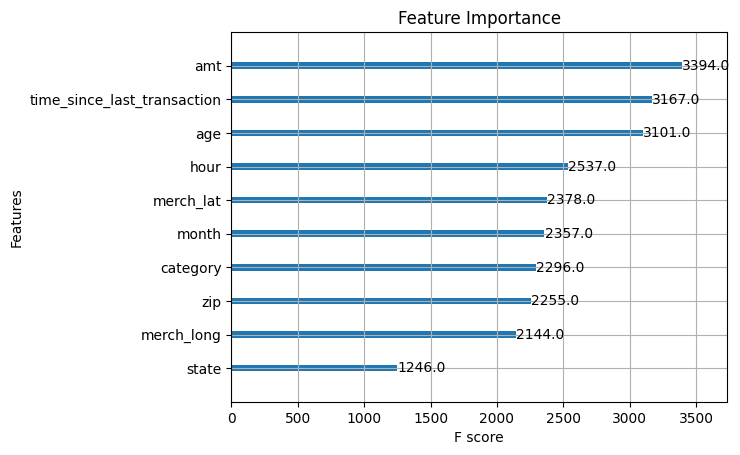

In [49]:
xgb.plot_importance(xgb_model, max_num_features=10)  
plt.title('Feature Importance')
plt.show()

ROC Curve

The Receiver Operating Characteristic (ROC) curve is an important tool for evaluating the performance of classification models. In the ROC graph in this project we can see a visual summary of the trade-off between the true positive rate (sensitivity) and the false positive rate (1-specificity) at various threshold settings.

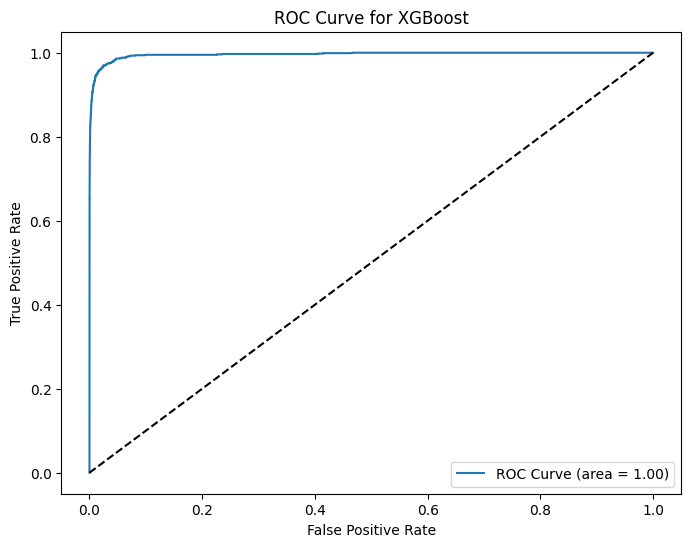

In [53]:
y_probs = xgb_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc='lower right')
plt.show()

Another informative visualisation is the confusion matrix, which shows true positives, false positives, true negatives, and false negatives.

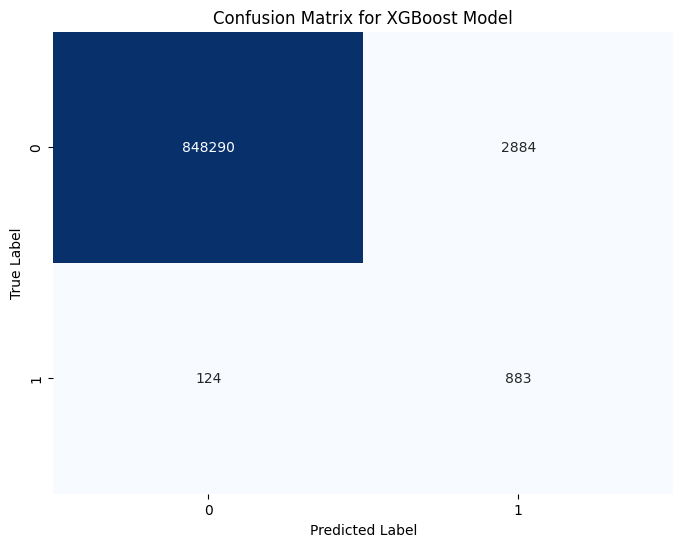

In [54]:
y_pred = xgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for XGBoost Model')
plt.show()